In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Sampling layer allows model to sample from the latent space and add elements to generate diverse outputs. It is used in Decoder witb the input coming from the encoder.

In [16]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs # Using logarithm because it is a stable function
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

Dense Layers with 100 and 150 nuerons

In [17]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

# Code for latent space that captures the hidden, common, and most important features of the dataset. Uses this data to generate new data.
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ

# Used for generating data
codings = Sampling()([codings_mean, codings_log_var])

# Create the encoder model.
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]) # Input: images, Output: Latent distributions

In [18]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size]) # Codings from latent space is passed to the decoder.

# Reconstricting layers
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x) # Outputs a vector that is the same size as the input (flat vector)
outputs = tf.keras.layers.Reshape([28, 28])(x) # Reshaped into an image
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [19]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [20]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [21]:
# extra code – loads, scales, and splits the MNIST dataset
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [22]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 7ms/step - loss: 0.0564 - val_loss: 0.0468
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0452 - val_loss: 0.0436
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0433 - val_loss: 0.0424
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0422 - val_loss: 0.0414
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0416 - val_loss: 0.0409
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0411 - val_loss: 0.0406
Epoch 7/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0407 - val_loss: 0.0402
Epoch 8/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0405 - val_loss: 0.0399
Epoch 9/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0402 - val_loss: 0.0397
Epoch 10/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0400 - val_loss: 0.0397

In [23]:
import matplotlib.pyplot as plt
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 129ms/step


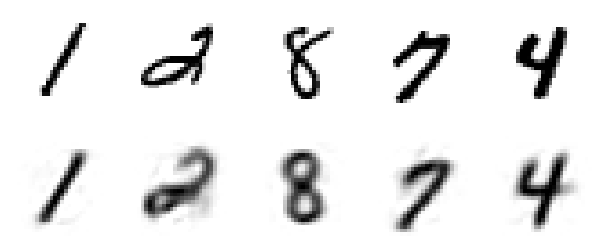

In [24]:
plot_reconstructions(variational_ae)
plt.show()

**Generate Digit Images**

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

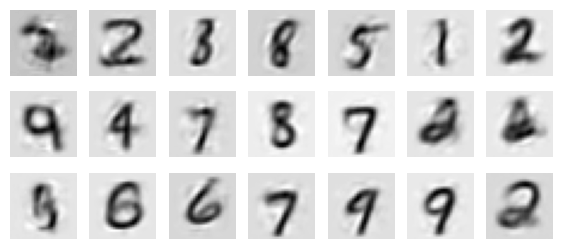

In [26]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

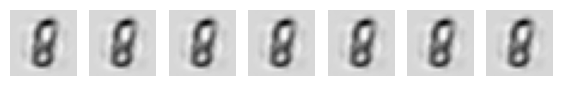

In [28]:
plot_multiple_images(images)
plt.show()